In [1]:
%load_ext autoreload
%autoreload 2

# Sakura Mini-Project

## Purpose:

Descripitve analysis on the Cherry Blossom data set to uncover trends in the peak bloom days for Kyoto sakura over time.

## Data Set: 

Historical Series of Phenological data for Cherry Tree Flowering at Kyoto City
(and March Mean Temperature Reconstructions) by Aono and Kazui, 2008; Aono and Saito, 2010; Aono, 2012.

[Data Set Website](http://atmenv.envi.osakafu-u.ac.jp/aono/kyophenotemp4/)

In [2]:
import os
import sys
gparent = os.path.join(os.pardir, os.pardir)
sys.path.append(gparent)

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns


import statsmodels.api as sm
from statsmodels.formula.api import ols
from statsmodels.stats.diagnostic import linear_rainbow, het_breuschpagan

from src import visuals as vz
from src import functions as fn

%matplotlib inline 
plt.style.use('fivethirtyeight')
pd.set_option('display.max_colwidth', None)

In [3]:
sakura_path = os.path.join(gparent,'data', 'KyotoFullFlower7.xls')
df = pd.read_excel(sakura_path)

In [4]:
temp_path = os.path.join(gparent, 'data', 'TempReconst7Final.xls')
temp = pd.read_excel(temp_path)

In [5]:
df.shape, temp.shape

((1240, 6), (1196, 7))

In [6]:
df.head(30)

,"Full-flowering dates of Japanese cherry (Prunus jamasakura) at Kyoto, Japan. (Latest version, Jun. 12, 2012)",Unnamed: 1,Unnamed: 2,Unnamed: 3,Unnamed: 4,Unnamed: 5
0,This phenological data was acquired by following studies.,NaN,NaN,NaN,NaN,NaN
1,NaN,NaN,NaN,NaN,NaN,NaN
2,Column A; A.D.,NaN,NaN,NaN,NaN,NaN
3,Column B; Full-flowering date (day of year).,NaN,NaN,NaN,NaN,NaN
4,"Column C; Full-flowering date (calender date, e.g. 402 --> April 2).",NaN,NaN,NaN,NaN,NaN
5,Column D; Source code,NaN,NaN,NaN,NaN,NaN
6,"1; Reported by Taguchi (1939), J. Marine Meteorol. Soc. (Umi to Sora), 19, 217-227",NaN,NaN,NaN,NaN,NaN
7,"2; Added by Sekiguchi (1969), Tokyo Geography Papers, 13, 175-190.",NaN,NaN,NaN,NaN,NaN
8,"3; Added by Aono and Omoto (1994), J. Agric. Meteorol., 49, 263-272.",NaN,NaN,NaN,NaN,NaN
9,"4; Added by Aono and Kazui (2008), Int. J. Climatol., 28, 905-914 (doi: 10.1002/joc.1594).",NaN,NaN,NaN,NaN,NaN


In [7]:
# setting data_key data frame 
key = df.iloc[0:23, 0:1].drop(1).reset_index(drop=True)

In [8]:
# checking key
key.head(2)

,"Full-flowering dates of Japanese cherry (Prunus jamasakura) at Kyoto, Japan. (Latest version, Jun. 12, 2012)"
0,This phenological data was acquired by following studies.
1,Column A; A.D.


In [9]:
# setting column names from column_name row
df.columns = df.iloc[24]

# dropping data seperation rows and column_name row
df = df.drop([1, 23, 24])

# removing name from index
df.columns.name = None

# dropping nulls
df.dropna(inplace=True)

# reseting index
df = df.reset_index(drop=True)

In [10]:
# checking work
df.head()

,AD,Full-flowering date (DOY),Full-flowering date,Source code,Data type code,Reference Name
0,812,92,401,1,2,NIHON-KOKI
1,815,105,415,1,2,NIHON-KOKI
2,831,96,406,1,2,NIHON-KOKI
3,851,108,418,1,2,MONTOKUTENNO-JITSUROKU
4,853,104,414,1,2,MONTOKUTENNO-JITSUROKU


In [11]:
# checking datatypes
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 825 entries, 0 to 824
Data columns (total 6 columns):
 #   Column                     Non-Null Count  Dtype 
---  ------                     --------------  ----- 
 0   AD                         825 non-null    object
 1   Full-flowering date (DOY)  825 non-null    object
 2   Full-flowering date        825 non-null    object
 3   Source code                825 non-null    object
 4   Data type code             825 non-null    object
 5   Reference Name             825 non-null    object
dtypes: object(6)
memory usage: 38.8+ KB


In [12]:
# converting strings to ints
strings = ['AD', 'Full-flowering date (DOY)', 'Full-flowering date']
df[strings] = df[strings].apply(pd.to_numeric)

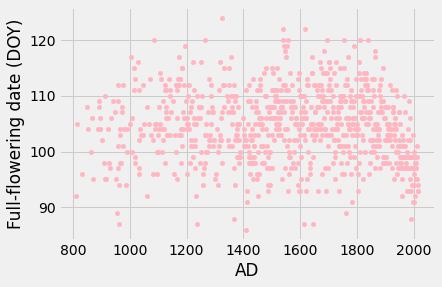

In [13]:
df.plot.scatter(x='AD', y='Full-flowering date (DOY)', color='lightpink');

In [14]:
# adding 5-year moving average feature
df['5_Year_Ave'] = df['Full-flowering date (DOY)'].rolling(5).mean()

In [15]:
# adding a mean peak value column
df['Mean Peak'] = df['Full-flowering date (DOY)'].mean()

In [16]:
# checking work
print(df.info())
df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 825 entries, 0 to 824
Data columns (total 8 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   AD                         825 non-null    int64  
 1   Full-flowering date (DOY)  825 non-null    int64  
 2   Full-flowering date        825 non-null    int64  
 3   Source code                825 non-null    object 
 4   Data type code             825 non-null    object 
 5   Reference Name             825 non-null    object 
 6   5_Year_Ave                 821 non-null    float64
 7   Mean Peak                  825 non-null    float64
dtypes: float64(2), int64(3), object(3)
memory usage: 51.7+ KB
None


,AD,Full-flowering date (DOY),Full-flowering date,Source code,Data type code,Reference Name,5_Year_Ave,Mean Peak
0,812,92,401,1,2,NIHON-KOKI,NaN,104.556364
1,815,105,415,1,2,NIHON-KOKI,NaN,104.556364
2,831,96,406,1,2,NIHON-KOKI,NaN,104.556364
3,851,108,418,1,2,MONTOKUTENNO-JITSUROKU,NaN,104.556364
4,853,104,414,1,2,MONTOKUTENNO-JITSUROKU,101.0,104.556364


In [17]:
# checking temp data
temp.head(30)

,TempReconst7Final.xls,Unnamed: 1,Unnamed: 2,Unnamed: 3,Unnamed: 4,Unnamed: 5,Unnamed: 6
0,Reconstructed value of March mean temperature at Kyoto City,NaN,NaN,NaN,NaN,NaN,NaN
1,"801-1400 A.D. : Aono and Saito (2010): International Journal of Biometeorology, 54, 211-219",NaN,NaN,NaN,NaN,NaN,NaN
2,"1401-1990 A.D. : Aono and Kazui (2008): International Journal of Climatology, 28, 905-914",NaN,NaN,NaN,NaN,NaN,NaN
3,"Partly modified by Aono (2012): Chikyu Kankyo (Global Environment), 17, 21-29",NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,Column B; Reconstructed temperature deduced from 5 or more years phenological data in each 31-year time span used for smoothing by local linear regression.,NaN,NaN,NaN,NaN,NaN,NaN
6,Column C; upper limit of 95% confidence intervals in smoothing procedure for temperature estimates.,NaN,NaN,NaN,NaN,NaN,NaN
7,Column D; lower limit of 95% confidence intervals in smoothing procedure for temperature estimates.,NaN,NaN,NaN,NaN,NaN,NaN
8,"Column E; observed temperature, smoothed by same procedure for temperature estimates.",NaN,NaN,NaN,NaN,NaN,NaN
9,Column F; Urban warming bias was obscured (Using Hikone weather station as a control site).,NaN,NaN,NaN,NaN,NaN,NaN


In [18]:
# getting temp data key
temp_key = temp.iloc[0:12, 0:1].drop([4,11]).reset_index(drop=True)

In [19]:
# checking key
temp_key

,TempReconst7Final.xls
0,Reconstructed value of March mean temperature at Kyoto City
1,"801-1400 A.D. : Aono and Saito (2010): International Journal of Biometeorology, 54, 211-219"
2,"1401-1990 A.D. : Aono and Kazui (2008): International Journal of Climatology, 28, 905-914"
3,"Partly modified by Aono (2012): Chikyu Kankyo (Global Environment), 17, 21-29"
4,Column B; Reconstructed temperature deduced from 5 or more years phenological data in each 31-year time span used for smoothing by local linear regression.
5,Column C; upper limit of 95% confidence intervals in smoothing procedure for temperature estimates.
6,Column D; lower limit of 95% confidence intervals in smoothing procedure for temperature estimates.
7,"Column E; observed temperature, smoothed by same procedure for temperature estimates."
8,Column F; Urban warming bias was obscured (Using Hikone weather station as a control site).
9,"Column G; Same as Column F, except for using Kameoka weather station as a control site.."


In [20]:
# getting column names
temp.columns = temp.iloc[15]

# dropping row with column names
temp.drop(15, inplace=True)

# dropping index name
temp.columns.name = None

In [21]:
# dropping nulls
temp.dropna(inplace=True)

# dropping rows with missing estimated temperatures 
# -50 was used by the authors to denote missing temp values
index_names = temp[temp['Estimated temperature']==-50].index
temp.drop(index_names, inplace=True)

# resetting index
temp = temp.reset_index(drop=True)

In [22]:
# converting datatypes
temp = temp.apply(pd.to_numeric)

# adding fahrenheit column
temp['F'] = (9/5)*temp['Estimated temperature']+32

In [23]:
print(temp.shape)
temp.head()

(1123, 8)


,AD,Estimated temperature,Upper limit,Lower limit,Observed temperature,Urban bias was subtracted (Hikone),Urban bias was subtracted (Kameoka),F
0,854,5.87,10.99,0.75,-50.0,5.87,5.87,42.566
1,855,5.99,10.78,1.21,-50.0,5.99,5.99,42.782
2,856,6.12,10.60,1.64,-50.0,6.12,6.12,43.016
3,857,6.25,10.47,2.02,-50.0,6.25,6.25,43.250
4,858,6.37,10.39,2.35,-50.0,6.37,6.37,43.466


In [24]:
# joining data frames
merged = df.merge(temp, on='AD')

In [25]:
# checking work
merged.head()

,AD,Full-flowering date (DOY),Full-flowering date,Source code,Data type code,Reference Name,5_Year_Ave,Mean Peak,Estimated temperature,Upper limit,Lower limit,Observed temperature,Urban bias was subtracted (Hikone),Urban bias was subtracted (Kameoka),F
0,864,100,409,1,2,NIPPON-SANDAI-JITSUROKU,102.6,104.556364,7.13,11.31,2.95,-50.0,7.13,7.13,44.834
1,866,106,416,1,2,NIPPON-SANDAI-JITSUROKU,102.8,104.556364,7.38,12.10,2.66,-50.0,7.38,7.38,45.284
2,891,109,419,5,4,NIHONKIRYAKU,102.8,104.556364,5.60,7.05,4.15,-50.0,5.60,5.60,42.080
3,892,108,417,5,3,FUSHIMIIN-GOKIROKKU,104.4,104.556364,5.71,7.00,4.42,-50.0,5.71,5.71,42.278
4,894,106,416,5,2,KANKE-BUNSOU,104.4,104.556364,5.95,7.66,4.24,-50.0,5.95,5.95,42.710


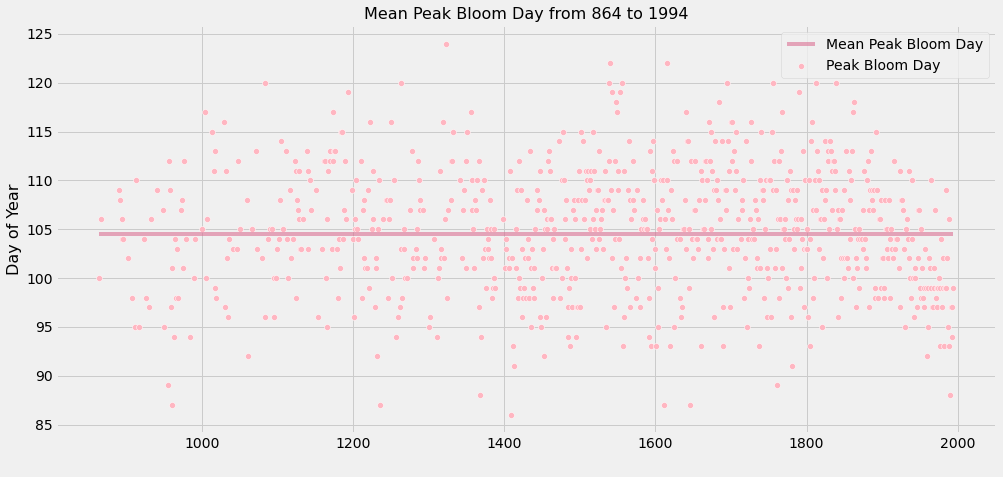

In [26]:
vz.mean_plot(merged)

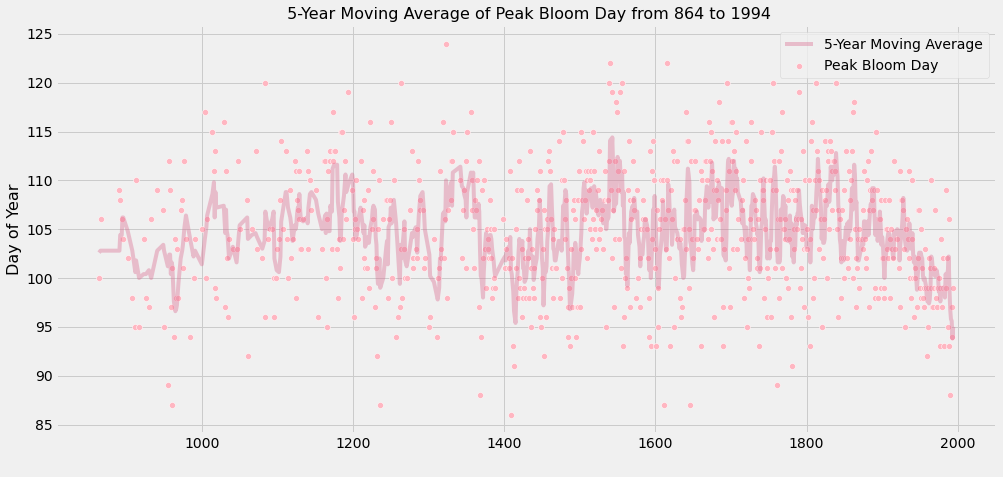

In [27]:
vz.sakura_plot(merged)

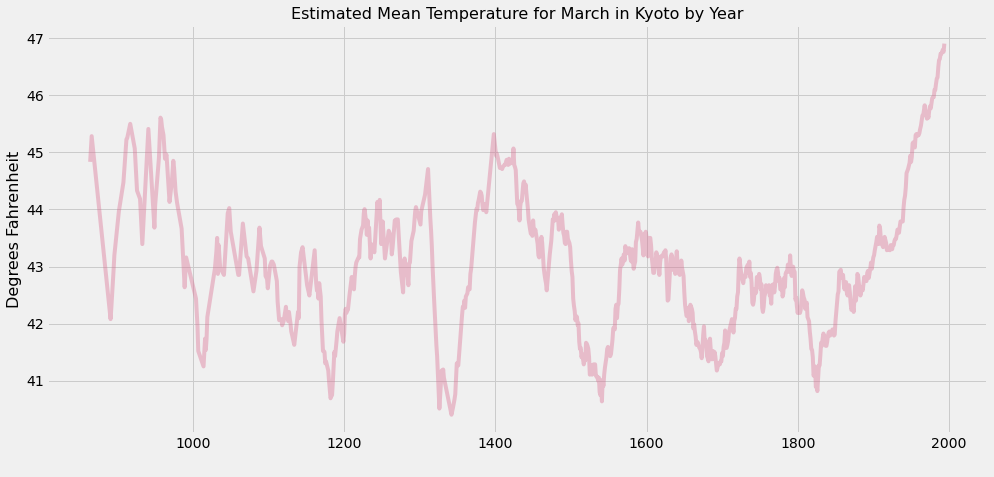

In [28]:
vz.temp_plot(merged)

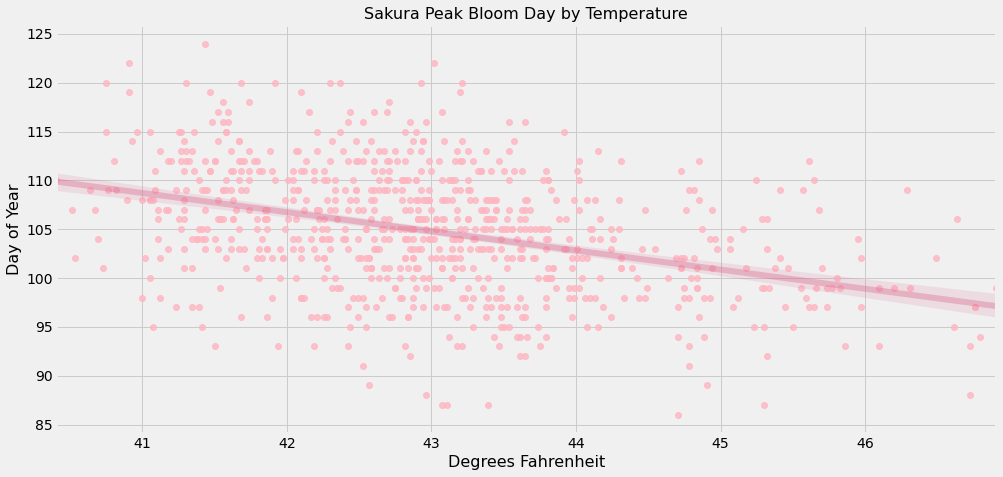

In [29]:
vz.temp_day_plot(merged)

## Linear Regression

A simple linear regression model was created with `Full-flowering date (DOY)` as the target and `F` (Mean Temp in Kyoto for March) as the predictor. R-squared and the correlation coefficient for the fahrenheit temperature feature were found and the data and model were checked for adherence to the assumptions of linear reggression. 
A significance level of alpha = .05 was used for all statistical tests.

In [30]:
simple_df = merged[['Full-flowering date (DOY)', 'F']].copy()

In [31]:
simple_df['Day'] = simple_df['Full-flowering date (DOY)']

In [32]:
model = ols(formula="Day ~ F", data=simple_df)
results = model.fit()

In [33]:
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    Day   R-squared:                       0.146
Model:                            OLS   Adj. R-squared:                  0.145
Method:                 Least Squares   F-statistic:                     135.5
Date:                Sun, 04 Apr 2021   Prob (F-statistic):           5.08e-29
Time:                        02:34:31   Log-Likelihood:                -2534.9
No. Observations:                 797   AIC:                             5074.
Df Residuals:                     795   BIC:                             5083.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept    189.1378      7.248     26.094      0.000     174.910     203.366
F             -1.9617      0.169    -11.639      0.000      -2.293      -1.631
==============================================================================
Omnibus:                        0.796   Durbin-Watson:                   2.042
Prob(Omnibus):                  0.672   Jarque-Bera (JB):                0.703
Skew:                          -0.069   Prob(JB):                        0.704
Kurtosis:                       3.047   Cond. No.                     1.51e+03
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.51e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

## Interpretation

Our intercept suggests that for an average March temperature in Kyoto of 0 degrees fahrenheit, the mean peak bloom day will occur on the 189th day of the year. The fahrenheit (F) coefficient indicates that for every 1 degree rise in mean March temperature, the peak bloom day will occur 1.96 days earlier on average. Lastly, the model's r-squared value of .146 says that around 14% of the variance in peak bloom dates can be accounted for through the mean March temperature in Kyoto.

### Linearity Check: Rainbow Test
Ho: The model is linearly predicted by the features.

Ha: The Model is not linearly predicted by the features.

In [34]:
fn.rainbow(results)

Rainbow statistic: 0.8556642516091699
Rainbow p-value: 0.9397165963405847


#### Results: Pass
Since the p-value is greater than .05, we fail to reject the null hypothesis and conclude that the model is linearly predicted by the features.  

### Normality of Residuals Check: Jarque-Bera
Ho: The residuals are normally distributed.

Ha: The residuals are not normally distributed.

#### Results: Pass

Since the JB p-value is greater than .05, we fail to reject the null hypothesis and find that the residuals are normaly distributed.

### Homoscedasticity Check: Inspection of the Residuals & Breusch-Pagan Test
Plotting the errors (actual sale price - predicted sale price) against the predicted sale price and performing a Breusch-Pagan test.

For the Breusch-Pagan Test:

Ho: The variance of the target is homogeneous across all values of the predictors.

Ha: The variance of the target is not homogeneous across all values of the predictors.

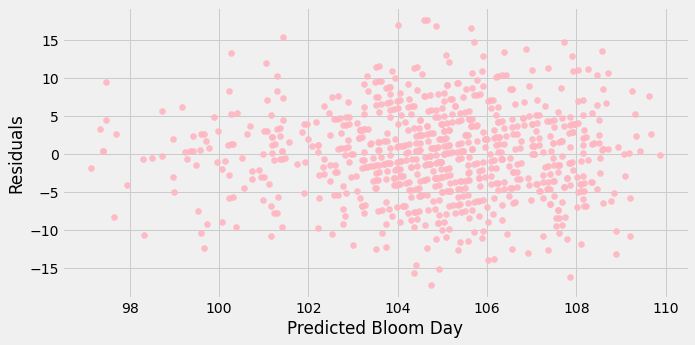

In [35]:
vz.error_plot(simple_df, 'Day', results)

The residuals look reasonably distributed in the error-plot.

In [36]:
y = simple_df['Day']
y_hat = results.predict()
lm, lm_p_value, fvalue, f_p_value = het_breuschpagan(y-y_hat, simple_df[['F']])
print('Lagrange Multiplier p-value:', lm_p_value)
print('F-statistic p-value:', f_p_value)

Lagrange Multiplier p-value: nan
F-statistic p-value: 2.2723811886274197e-70


#### Result: Fail

Since the BP test p-value was close to 0, we reject the null hypothesis and conclude that the residalus are not homogeneous across all values of the predictors.

### Independence Check: N/A

Since the model only has one predictor, it is independent by definition.